<a href="https://colab.research.google.com/github/yamaguchinorimitsu/ajax_app/blob/master/%E3%82%B9%E3%83%83%E3%82%AD%E3%83%AA%E6%A9%9F%E6%A2%B0%E7%AC%AC11%E7%AB%A0%E7%B7%B4%E7%BF%92%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv('/content/Bank.csv')
print(df.shape)
df.head()

(27128, 16)


,id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
0,1,39,blue-collar,married,secondary,no,1756.0,yes,no,cellular,3,apr,370.055237,1,0,1
1,2,51,entrepreneur,married,primary,no,1443.0,no,no,cellular,18,feb,233.998933,10,0,1
2,3,36,management,single,tertiary,no,436.0,no,no,cellular,13,apr,NaN,1,2,0
3,4,63,retired,married,secondary,no,474.0,no,no,cellular,25,jan,252.525808,1,0,0
4,5,31,management,single,tertiary,no,354.0,no,no,cellular,30,apr,NaN,1,2,0


In [3]:
# まず、ダミー変数化をしたいが、文字列の列が複数あるので抜き出す。
str_col_name=['job','default','marital','education','housing','loan','contact','month']
str_df = df[str_col_name]
#複数列を一気にダミー変数化
str_df2=pd.get_dummies(str_df,drop_first=True)

num_df = df.drop(str_col_name,axis=1)#数値列を抜き出す
df2 = pd.concat([num_df,str_df2,str_df],axis=1)#結合(今後の集計の利便性も考慮してstr_dfも結合しておく)

In [ ]:
#訓練&検証データとテストデータに分割
train_val,test = train_test_split(df2,test_size=0.1,random_state=9)
train_val.head()

In [5]:
#特徴量の当たりがついた
#しかし、そもそもこの線形回帰は外れ値の影響を強く受けるので調べる。
from sklearn.covariance import MinCovDet
num_df=train_val.drop(str_col_name,axis=1)
num_df=num_df.drop('id',axis=1)
num_df2=num_df.dropna()
mcd2 =MinCovDet(random_state=0,support_fraction=0.7)
mcd2.fit(num_df2)

MinCovDet(random_state=0, support_fraction=0.7)

<Axes: >

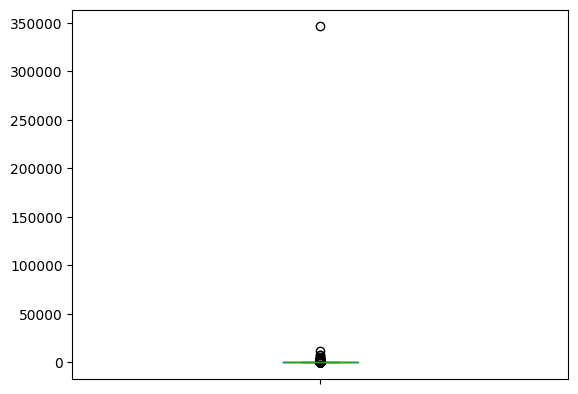

In [6]:
dis =mcd2.mahalanobis(num_df2)
dis=pd.Series(dis)
dis.plot(kind="box")


In [8]:
no=dis[dis>300000].index
#先頭から2561番目が外れ値となる事が分かったので９章の付録で紹介したilocを利用する
no=num_df2.iloc[no[0]:(no[0]+1),:].index
train_val2 = train_val.drop(no)

In [9]:
#欠損行を削除
not_nan_df = train_val2.dropna()
temp_t =not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name,axis=1)

#durationとyに関係があるという仮定が成り立つならば、適切な推定をするためには,
temp_x = temp_x.drop(['y','duration','id'],axis=1)
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso,Ridge

a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)
maxvalue=0
v=0
#今回はLasso回帰を利用するので、特徴量選択はしない
for i in range(1,42):
    val = i/20
    model_liner = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner.fit(a,c)
    if maxvalue < model_liner.score(b,d):
        v=val
        maxvalue = model_liner.score(b,d)
print(v,maxvalue)

0.15 0.7304944115519963


In [10]:
model_liner = Lasso(random_state=0,alpha=v)
#今回は予測させたいだけなので、標準化はしない
model_liner.fit(a,c)
#pd.Series(model_liner)

Lasso(alpha=0.15, random_state=0)

In [11]:
# 考え方をここで変える。durationとyに関係が強いという仮定が正しいならば、durationを推定するのに
#yを利用するのは合理的ではなかろうか？ただテストデータでは、yの値が本当に未知という状況で検証するので
#テストデータでもdurationが欠損している場合は上記model_linerを利用する。
#欠損行を削除
not_nan_df = train_val2.dropna()
temp_t =not_nan_df[['duration']]
temp_x = not_nan_df.drop(str_col_name,axis=1)
#yを消さない
temp_x = temp_x.drop(['duration','id'],axis=1)
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso,Ridge

a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)
maxvalue=0
v=0
for i in range(1,42):
    val = i/20
    model_liner2 = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner2.fit(a,c)
    if maxvalue < model_liner2.score(b,d):
        v=val
        maxvalue = model_liner2.score(b,d)
print(v,maxvalue)

0.1 0.8192780104182655


In [12]:
#結果
pd.Series(model_liner2.coef_,index=temp_x.columns)

age                            3.685596
amount                        -0.000010
day                           -0.000000
campaign                      -0.000000
previous                       2.951859
y                             41.674580
job_blue-collar                0.000000
job_entrepreneur              -0.000000
job_housemaid                 -0.000000
job_management                -0.000000
job_retired                   -0.000000
job_self-employed              0.000000
job_services                   0.000000
job_student                   -0.000000
job_technician                 0.000000
job_unemployed                -0.000000
job_unknown                   -0.000000
default_yes                    0.000000
marital_married                0.000000
marital_single                -0.000000
education_secondary            0.000000
education_tertiary            -0.000000
education_unknown             -0.000000
housing_yes                  127.082018
loan_yes                      82.595567


In [13]:
train_val3 = train_val.copy()
is_null=train_val3['duration'].isnull()
#temp_x = tain_val3.drop(str_col_name,axis=1)
#修正
temp_x = train_val3.drop(str_col_name,axis=1)

temp_x = temp_x.drop(['duration','id'],axis=1)
temp_x = temp_x[is_null]
#non_x=train_val2.loc[is_null,['housing_yes','loan_yes','age','marital_single','job_student']]
pred_d = model_liner2.predict(temp_x)
train_val3.loc[is_null,'duration']=pred_d

(24415, 48)

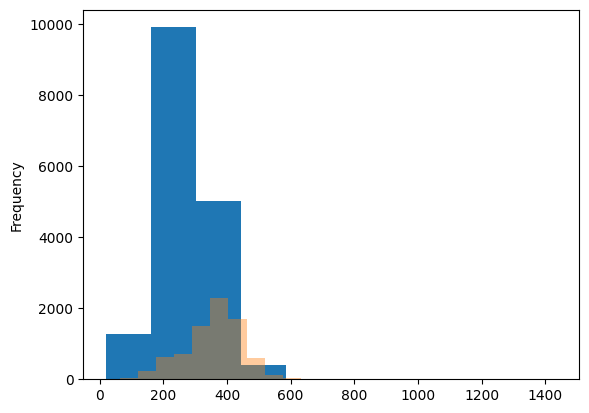

In [14]:
#ヒストグラムの確認
train_val3.loc[train_val3['y']==0,"duration"].plot(kind="hist")
train_val3.loc[train_val3['y']==1,"duration"].plot(kind="hist",alpha=0.4)

#y=1の方が、durationが大きい傾向がやっぱりありそう
train_val3.shape

In [15]:
train_val3["duration"].describe()

count    24415.000000
mean       297.012163
std         92.504680
min         19.038719
25%        227.001265
50%        292.726974
75%        362.290315
max       1435.488040
Name: duration, dtype: float64

In [16]:
#まず、さくっと学習できるようなlearn関数を定義する。
def learn(x,t,i):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    #不均衡データに対応できるように、class_weight引数も設定
    model = tree.DecisionTreeClassifier(random_state=i,max_depth=i,class_weight='balanced')
    model.fit(x_train,y_train)
    train_score=model.score(x_train,y_train)
    
    
    val_score=model.score(x_val,y_val)
    return train_score,val_score,model,datas

t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
#とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(1,15):
    s1,s2,model,datas = learn(x,t,i)
    print(i,s1,s2)

1 0.754351832889617 0.7565021503174278
2 0.754351832889617 0.7565021503174278
3 0.7117038705713701 0.708171206225681
4 0.7706328077001843 0.7765717796436616
5 0.7595740323571575 0.7513823469178783
6 0.7923919721482695 0.7855826336268688
7 0.8189637517919311 0.8046283022731927
8 0.8383166086422281 0.8220356338316609
9 0.8561847225066558 0.8193733360638952
10 0.8741040344050789 0.821421257423715
11 0.8882346917878353 0.8179397911120213
12 0.9068195781281999 0.8185541675199672
13 0.9212062256809338 0.810976858488634
14 0.9369752201515462 0.8130247798484538


pred     0     1
true            
0     2825   558
1      311  1189


<Axes: >

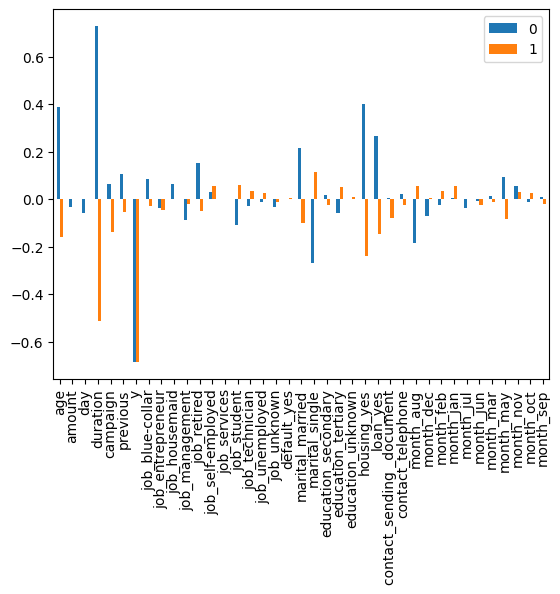

In [17]:
#どのような間違い方をしているのか確認
s1,s2,model,datas = learn(x,t,8)

#訓練データでの予測結果と実際の値の2軸で個数集計flagがFalseならば、検証データで集計
def syuukei(model,datas,flag=False):
    if flag:
        pre=model.predict(datas[0])
        y_val=datas[2]
    else:
        pre=model.predict(datas[1])
        y_val=datas[3]
    data={
        "pred":pre,
        "true":y_val
    }
    tmp=pd.DataFrame(data)
    return tmp,pd.pivot_table(tmp,index="true",columns="pred",values="true",aggfunc=len)
tmp,a=syuukei(model,datas,False)
print(a)
from sklearn.preprocessing import StandardScaler
false=tmp.loc[(tmp['pred']==1)&(tmp['true']==0)].index
true=tmp.loc[(tmp['pred']==0)&(tmp['true']==0)].index
true_df=train_val3.loc[true]
false_df=train_val3.loc[false]
sc = StandardScaler()
tmp2=train_val3.drop(str_col_name,axis=1)
sc_data = sc.fit_transform(tmp2)
sc_df = pd.DataFrame(sc_data,columns=tmp2.columns,index=tmp2.index)

true_df=sc_df.loc[true]
false_df=sc_df.loc[false]
true_df
temp2=pd.concat([false_df.mean()["age":],true_df.mean()["age":]],axis=1)
temp2.plot(kind="bar")

In [18]:
#交互作用項を付けてみる
train_val4=train_val3.copy()
train_val4['du*hou']=train_val3['duration']*train_val3['housing_yes']
train_val4['du*loan']=train_val3['duration']*train_val3['loan_yes']
train_val4['du*age']=train_val3['duration']*train_val3['age']

t =train_val4['y']
"""
monthcol=['month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']
#jobcol=['job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown']
"""

x = train_val4.drop(str_col_name,axis=1)

#x = x.drop(jobcol,axis=1)

#x = x.drop(monthcol,axis=1)
x =x.drop(['id','y','day'],axis=1)
x.columns

Index(['age', 'amount', 'duration', 'campaign', 'previous', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'default_yes', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'education_unknown', 'housing_yes', 'loan_yes',
       'contact_sending _document', 'contact_telephone', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'du*hou', 'du*loan', 'du*age'],
      dtype='object')

In [19]:
#とりあえず、for文で様々な木の深さでの正解率を調べてみる
for i in range(5,15):
    s1,s2,model,datas = learn(x,t,i)
    print(i,s1,s2)

5 0.7591644480851936 0.7505631783739505
6 0.7908560311284046 0.7823059594511571
7 0.8201925046078231 0.8058570550890846
8 0.8384190047102191 0.8191685439279132
9 0.8520376817530206 0.8083145607208683
10 0.8697010034814663 0.8103624820806881
11 0.8894634446037272 0.8179397911120213
12 0.9051300430063486 0.8087241449928323
13 0.9208990374769609 0.8101576899447062
14 0.9347737046897399 0.8117960270325619


In [20]:
#深さ８で正解率81% 先ほどより低下した。よって交互作用項は取る。
train_val4=train_val3.copy()
t =train_val4['y']
x = train_val4.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
i=8
model = tree.DecisionTreeClassifier(random_state=i,max_depth=i,class_weight="balanced")
model.fit(x,t)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=8)

In [21]:
#テストデータでも調べる
test2 = test.copy()    
isnull=test2['duration'].isnull()
print(isnull.shape)
if isnull.sum()>0:
    temp_x = test2.drop(str_col_name,axis=1)
    temp_x = temp_x.drop(['y','duration','id'],axis=1)
    #print(temp_x.shape[0])
    temp_x = temp_x[isnull]
    #ここではmodel_linerで調べる
    pred_d = model_liner.predict(temp_x)
    test2.loc[isnull,'duration']=pred_d
    

x_test = test2.drop(str_col_name,axis=1)
x_test =x_test.drop(['id','y','day'],axis=1)
y_test = test['y']
x_test.columns
model.score(x_test,y_test)

(2713,)


0.7648359749354957